<a href="https://colab.research.google.com/github/Jgallear/CSSP_brazil_23_24/blob/main/plot_GBM_shapley_values_1month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# construct ensemble of different models each constructed using sampling to emphasise different weather regimes

In [ ]:
!pip install cartopy
!pip install shap
#!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.2 MB/s eta 0:00:00


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from sklearn.inspection import PartialDependenceDisplay
from shapely.geometry import Point
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
#from rasterio import CRS
from shapely.geometry import mapping
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import functools
import pickle
import cartopy.feature as cf
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.svm import SVR
#import fastcluster
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import tensorflow as tf
import itertools
import shap

In [ ]:
# Get df already processed from other script and test different models / ensembles
df = pd.read_csv('/content/drive/MyDrive/VHI_spei_rzsm_dataset.csv')

In [ ]:
print(df)

           lon     lat      vhi-1   precip-1      rzsm-1  spei1-1m  spei2-1m  \
0      -53.375 -32.125  70.414172  259.20056   98.021910  2.192168  1.313241   
1      -53.375 -32.125  79.323750  146.58607   98.162980  1.228278  2.453098   
2      -53.375 -32.125  77.111895  184.82845   97.594270  1.472914  1.588110   
3      -53.375 -32.125  64.150561  108.86273   97.605330  1.680747  1.751371   
4      -53.375 -32.125  54.270359  145.90760  100.000000  1.641170  1.900034   
...        ...     ...        ...        ...         ...       ...       ...   
627650 -47.625  -0.875  49.922513  294.35620   80.138200  1.130223  0.881931   
627651 -47.625  -0.875  52.101102  125.48111   88.888840  2.664571  2.250521   
627652 -47.625  -0.875  46.753572   24.13338   77.834076  2.523025  3.002636   
627653 -47.625  -0.875  48.627606   71.58264   69.860950  1.286047  2.275886   
627654 -47.625  -0.875  47.450658  130.48245   83.223434  1.721121  1.885239   

        spei3-1m   spi01-1   spi02-1   

In [ ]:
df_vars = df.drop(columns=['month','year','lon','lat'])

In [ ]:
scaler = StandardScaler()
scaler.fit(df_vars)
X=scaler.transform(df_vars)

In [ ]:
pca = PCA()

In [ ]:
x_new = pca.fit_transform(X)

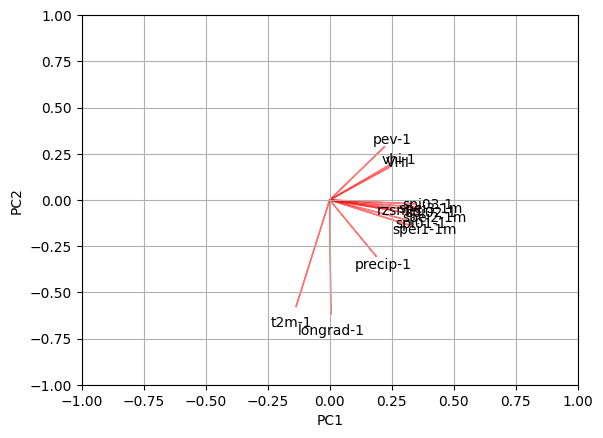

In [ ]:
def myplot(score,coeff,labels=df_vars.columns):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'k', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [ ]:
#sns.clustermap(df_vars)
#fastcluster.linkage(df_vars)


In [ ]:
def groupby_gc(df):
  df_list=[]
  for index,df in df.groupby(['lat','lon']):
    df_list.append(df)
  return df_list

In [ ]:
# produce maps of correlation between VHI and each of the df_vars variables
def per_gc_metrics(df,var='VHI'):
  m1_df_anom_gc_list = groupby_gc(df)
  lat_list=[]
  lon_list=[]
  vhi_averages=[]
  vhi_spei3_ccoefs=[]
  vhi_rzsm_ccoefs=[]
  vhi_precip_ccoefs=[]
  for i in range(len(m1_df_anom_gc_list)):
    # get average vhi and plot
    vhi_averages.append(np.mean(m1_df_anom_gc_list[i]['VHI']))
    vhi_spei3_ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['VHI'],m1_df_anom_gc_list[i][var])[0])

    # get latitude and longitude coordinates
    lat = m1_df_anom_gc_list[i]['lat'].values[0]
    lat_list.append(lat)
    lon = m1_df_anom_gc_list[i]['lon'].values[0]
    lon_list.append(lon)
  return lat_list, lon_list, vhi_spei3_ccoefs

In [ ]:
lat_list, lon_list, vhi_spi1_ccoefs = per_gc_metrics(df,'spi01-1')
lat_list, lon_list, vhi_spi2_ccoefs = per_gc_metrics(df,'spi02-1')
lat_list, lon_list, vhi_spi3_ccoefs = per_gc_metrics(df,'spi03-1')
## SPEI
lat_list, lon_list, vhi_spei1_ccoefs = per_gc_metrics(df,'spei1-1m')
lat_list, lon_list, vhi_spei2_ccoefs = per_gc_metrics(df,'spei2-1m')
lat_list, lon_list, vhi_spei3_ccoefs = per_gc_metrics(df,'spei3-1m')

In [ ]:
fname = '/content/drive/MyDrive/shapefiles/BR/BR_EST_SAD69.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none')


In [ ]:
print(np.min(vhi_spi3_ccoefs))

-0.09487563334088824


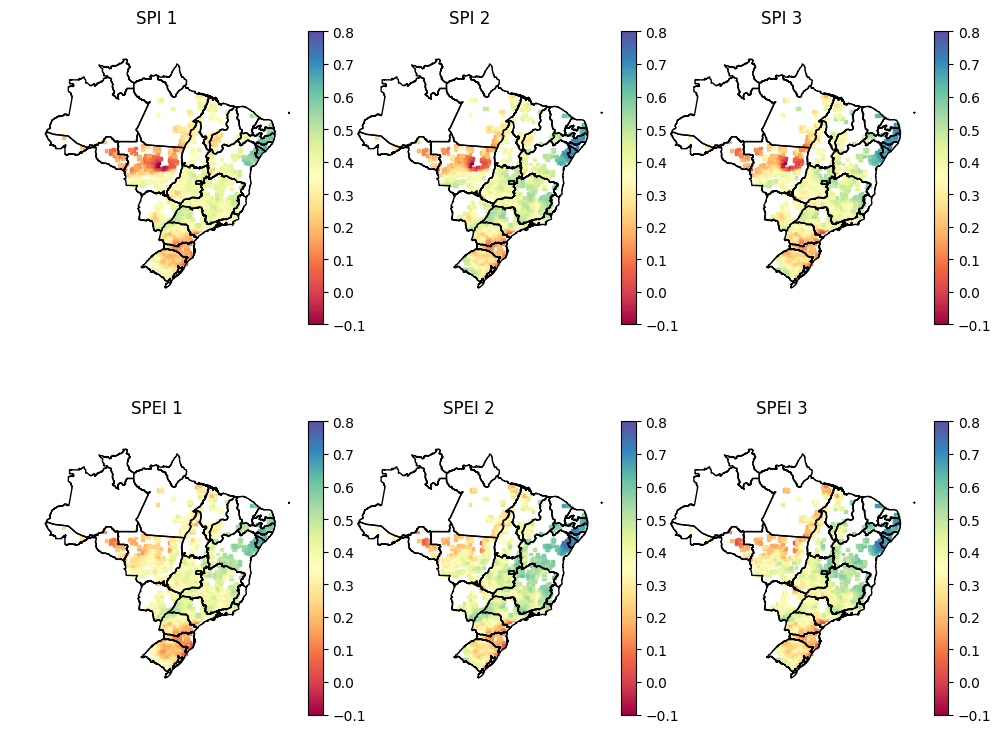

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2,3,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.set_title('SPI 1')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi2_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPI 2')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi3_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPI 3')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 1')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei2_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 2')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei3_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 3')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-0.5)
#plt.savefig('/content/drive/MyDrive/Figures/SPI_SPEI_comparison.png',dpi=300)
plt.show()

In [ ]:
lat_list, lon_list, vhi_vhim1_ccoefs = per_gc_metrics(df,'vhi-1')
lat_list, lon_list, vhi_rzsm_ccoefs = per_gc_metrics(df,'rzsm-1')
lat_list, lon_list, vhi_pr_ccoefs = per_gc_metrics(df,'precip-1')
## SPEI
lat_list, lon_list, vhi_pev_ccoefs = per_gc_metrics(df,'pev-1')
lat_list, lon_list, vhi_longrad_ccoefs = per_gc_metrics(df,'longrad-1')
lat_list, lon_list, vhi_t2m_ccoefs = per_gc_metrics(df,'t2m-1')

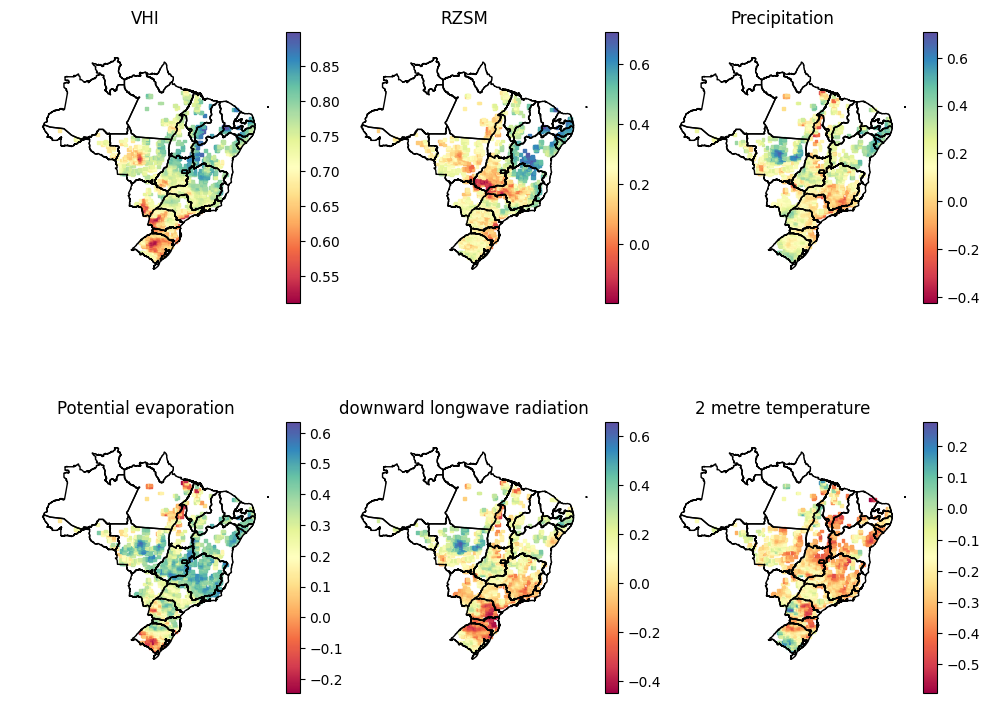

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2,3,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_vhim1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.set_title('VHI')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_rzsm_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('RZSM')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_pr_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('Precipitation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_pev_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('Potential evaporation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_longrad_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('downward longwave radiation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(2,3,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_t2m_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('2 metre temperature')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
#plt.savefig('/content/drive/MyDrive/Figures/other_input_vars_comparison.png',dpi=300)
plt.show()

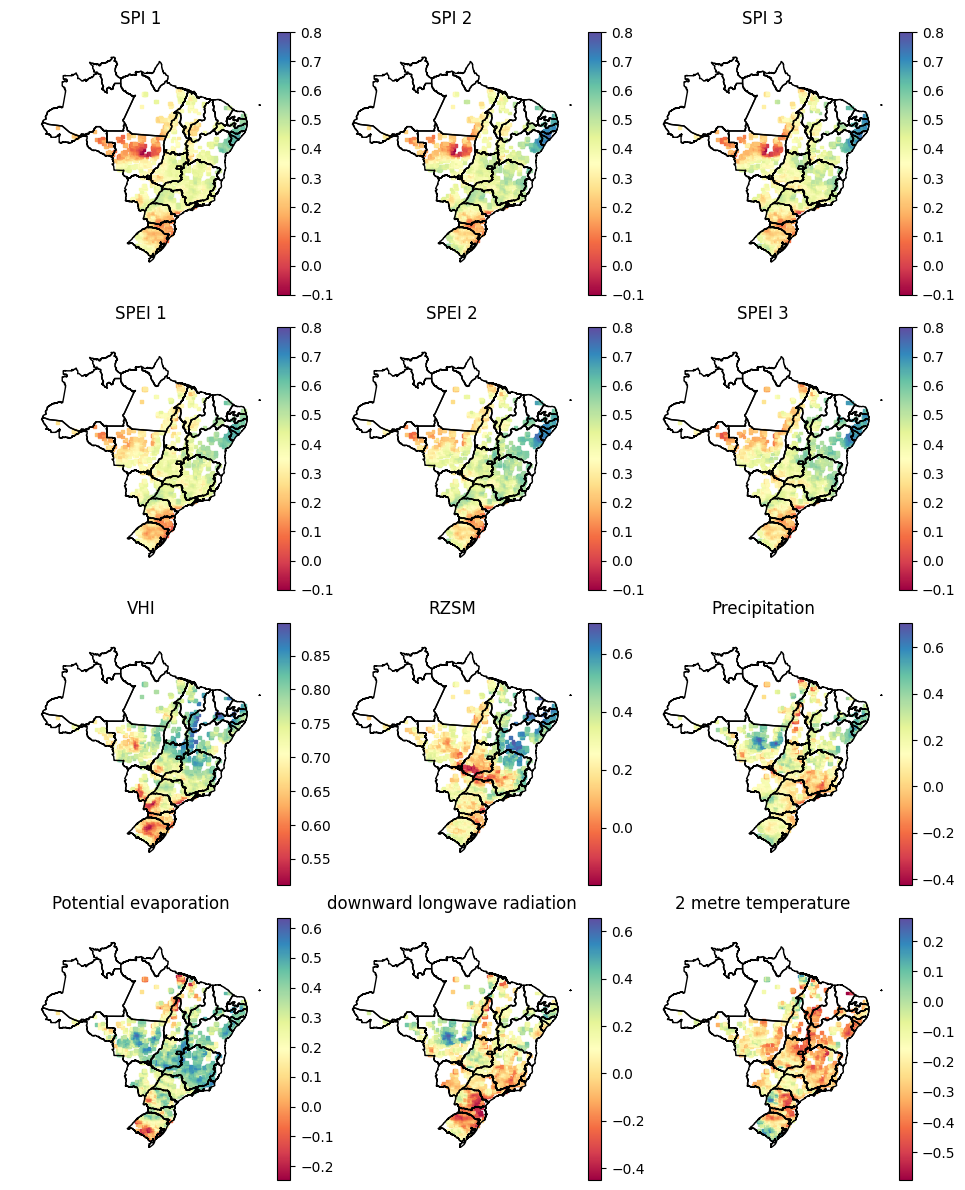

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(4,3,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.set_title('SPI 1')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi2_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPI 2')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spi3_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPI 3')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 1')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei2_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 2')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_spei3_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4,vmin=-0.1,vmax=0.8)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('SPEI 3')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,7,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_vhim1_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.set_title('VHI')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,8,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_rzsm_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('RZSM')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,9,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_pr_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('Precipitation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,10,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_pev_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('Potential evaporation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,11,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_longrad_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('downward longwave radiation')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')

ax1 = fig.add_subplot(4,3,12,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=vhi_t2m_ccoefs, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('2 metre temperature')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')




plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.125)
#plt.savefig('/content/drive/MyDrive/Figures/all_comparison.png',dpi=300)
plt.show()

In [ ]:
# construct boxplot of model performance from 10 different years for each model
# Use GBM, ANN, RFR, SVR, MLR, ridge regression, KNN, model which is just the historical average for each month (h-m mean)
# Get MAE mean absolute error and r2 score for each model
print(df)

           lon     lat      vhi-1   precip-1      rzsm-1  spei1-1m  spei2-1m  \
0      -53.375 -32.125  70.414172  259.20056   98.021910  2.192168  1.313241   
1      -53.375 -32.125  79.323750  146.58607   98.162980  1.228278  2.453098   
2      -53.375 -32.125  77.111895  184.82845   97.594270  1.472914  1.588110   
3      -53.375 -32.125  64.150561  108.86273   97.605330  1.680747  1.751371   
4      -53.375 -32.125  54.270359  145.90760  100.000000  1.641170  1.900034   
...        ...     ...        ...        ...         ...       ...       ...   
627650 -47.625  -0.875  49.922513  294.35620   80.138200  1.130223  0.881931   
627651 -47.625  -0.875  52.101102  125.48111   88.888840  2.664571  2.250521   
627652 -47.625  -0.875  46.753572   24.13338   77.834076  2.523025  3.002636   
627653 -47.625  -0.875  48.627606   71.58264   69.860950  1.286047  2.275886   
627654 -47.625  -0.875  47.450658  130.48245   83.223434  1.721121  1.885239   

        spei3-1m   spi01-1   spi02-1   

In [ ]:
df = df.rename(columns={'spei1-1m':'SPEI2 lag-1','spei2-1m':'SPEI2 lag-1','vhi-1':'VHI lag-1','precip-1':'precip lag-1','rzsm-1':'RZSM lag-1',
                        'spei3-1m':'SPEI3 lag-1','SPI01-1':'SPI1 lag-1','SPI02-1':'SPI2 lag-1','SPI03-1':'SPI3 lag-1','pev-1':'PEV lag-1','longrad-1':'longrad lag-1','t2m-1':'t2m lag-1'})

In [ ]:
years = np.arange(2003,2021+1)
rand10years = np.random.choice(years, 10)

In [ ]:
print(rand10years)

[2016 2010 2010 2007 2007 2018 2008 2020 2013 2009]


In [ ]:
fixed_years = [2020, 2007, 2020, 2004, 2012, 2020, 2019, 2003, 2021, 2005]

In [ ]:
fixed_years = [2016, 2011, 2019, 2015, 2006]

In [ ]:
def year_cross_val(data_df,model,years):
  predictions_list=[]
  r2_score_list = []
  mae_score_list =[]
  testy_list=[]
  test_lats_list=[]
  test_lons_list=[]
  test_months_list=[]
  test_years_list=[]
  testx_sc_list=[]
  for i in range(len(years)):
    test_yr_i = years[i]
    train_yr_data = data_df[data_df['year']!=test_yr_i]
    test_yr_data = data_df[data_df['year']==test_yr_i]
    # remove VHI for xy split
    trainx = train_yr_data.drop(columns=['VHI'])
    testx = test_yr_data.drop(columns=['VHI'])
    # y
    cols = testx.columns
    trainy = train_yr_data['VHI']
    testy = test_yr_data['VHI']#
    test_lats = test_yr_data['lat']
    test_lons = test_yr_data['lon']
    test_months = test_yr_data['month']
    test_years = test_yr_data['year']
    test_lats_list.append(test_lats)
    test_lons_list.append(test_lons)
    test_months_list.append(test_months)
    test_years_list.append(test_years)
    # for some models it is required that data is scaled to unit variance
    test_cols = testx.columns
    train_cols = trainx.columns
    scaler = StandardScaler()
    trainx_sc = scaler.fit_transform(trainx)
    testx_sc = scaler.transform(testx)
    print('train x')
    print(trainx)
    trainx_sc = pd.DataFrame(trainx_sc,columns=train_cols)
    testx_sc = pd.DataFrame(testx_sc,columns=test_cols)
    # fit model
    model.fit(trainx_sc,trainy)
    predictions_i = model.predict(testx_sc)
    testx_sc_list.append(pd.DataFrame(testx_sc,columns=cols))
    r2_score_i = r2_score(testy,predictions_i)
    mae_i = mean_absolute_error(testy, predictions_i)
    testy_list.append(testy)
    predictions_list.append(predictions_i)
    print('model ',i,' R2 score: ',r2_score_i)
    print('model ',i,' MAE score: ',mae_i)
    r2_score_list.append(r2_score_i)
    mae_score_list.append(mae_i)
    #print('lengths')
    #print(len(test_lats))
    #print(len(test_lons))
    #print(len(test_months))
    #print(len(predictions_i))
    #print(len(testy))
  # check length of each list which goes into out_df
  # use itertools function to join nested lists to do this
  out_df = pd.DataFrame({'lat':list(itertools.chain.from_iterable(test_lats_list)),'lon':list(itertools.chain.from_iterable(test_lons_list)),'month':list(itertools.chain.from_iterable(test_months_list)),'year':list(itertools.chain.from_iterable(test_years_list)),'prediction':list(itertools.chain.from_iterable(predictions_list)),'testy':list(itertools.chain.from_iterable(testy_list))})
  return r2_score_list,mae_score_list,predictions_list,testy_list, out_df, model, pd.concat(testx_sc_list)

In [ ]:
# define simple models
GBM_model = GradientBoostingRegressor(n_estimators=200)
RFR_model = RandomForestRegressor(n_estimators=200)
SVR_model = SVR(kernel='linear')
KNR_model = KNeighborsRegressor()
MLR_model = LinearRegression()
Ridge_model= Ridge()

In [ ]:
r2_score_MLR, mae_score_MLR,MLR_predictions,testy_list_MLR, MLR_out_df, MLR_model, testx_df = year_cross_val(df,model=MLR_model,years=fixed_years)

train x
           lon     lat  VHI lag-1  precip lag-1  RZSM lag-1  SPEI2 lag-1  \
0      -53.375 -32.125  70.414172     259.20056   98.021910     2.192168   
1      -53.375 -32.125  79.323750     146.58607   98.162980     1.228278   
2      -53.375 -32.125  77.111895     184.82845   97.594270     1.472914   
3      -53.375 -32.125  64.150561     108.86273   97.605330     1.680747   
4      -53.375 -32.125  54.270359     145.90760  100.000000     1.641170   
...        ...     ...        ...           ...         ...          ...   
627650 -47.625  -0.875  49.922513     294.35620   80.138200     1.130223   
627651 -47.625  -0.875  52.101102     125.48111   88.888840     2.664571   
627652 -47.625  -0.875  46.753572      24.13338   77.834076     2.523025   
627653 -47.625  -0.875  48.627606      71.58264   69.860950     1.286047   
627654 -47.625  -0.875  47.450658     130.48245   83.223434     1.721121   

        SPEI2 lag-1  SPEI3 lag-1   spi01-1   spi02-1   spi03-1  PEV lag-1  \
0 

In [ ]:
print(testx_df)
#testx_df.to_csv('/content/drive/MyDrive/model_outs/testx_df.csv',index=False)

            lon       lat  VHI lag-1  precip lag-1  RZSM lag-1  SPEI2 lag-1  \
0     -0.729705 -2.082827   1.143460      0.296723    1.558603     1.755121   
1     -0.729705 -2.082827   2.167281     -0.283627    1.619046    -0.665930   
2     -0.729705 -2.082827   1.843252      0.007963    0.751236    -0.496012   
3     -0.729705 -2.082827   1.752600      0.776522    1.346543     1.751790   
4     -0.729705 -2.082827   0.293512      3.425233    1.799337     1.376761   
...         ...       ...        ...           ...         ...          ...   
33307  0.401898  2.621449  -0.195822      0.854774    1.175695    -0.759763   
33308  0.401898  2.621449  -0.276035     -0.414668    1.535127     0.854848   
33309  0.401898  2.621449  -0.611952     -0.954601    0.966381    -0.832429   
33310  0.401898  2.621449  -0.695502     -1.077877    0.590119    -1.564185   
33311  0.401898  2.621449  -0.191061     -0.719959    1.238258     1.321800   

       SPEI2 lag-1  SPEI3 lag-1   spi01-1   spi02-1

In [ ]:
print(MLR_out_df)

           lat     lon  month  year  prediction      testy
0      -32.125 -53.375      1  2016   58.439285  74.811240
1      -32.125 -53.375      2  2016   64.013997  70.629659
2      -32.125 -53.375      3  2016   61.534514  69.459797
3      -32.125 -53.375      4  2016   66.373246  50.630339
4      -32.125 -53.375      5  2016   54.439150  57.133725
...        ...     ...    ...   ...         ...        ...
166555  -0.875 -47.625      8  2006   42.698212  43.236678
166556  -0.875 -47.625      9  2006   43.759618  38.822806
166557  -0.875 -47.625     10  2006   39.873725  37.724966
166558  -0.875 -47.625     11  2006   36.418750  44.353228
166559  -0.875 -47.625     12  2006   45.956292  42.623876

[166560 rows x 6 columns]


In [ ]:
# save results
#GBM_results_df = pd.DataFrame({'R2':r2_score_MLR,'MAE':mae_score_MLR})
#GBM_results_df.to_csv('/content/drive/MyDrive/model_outs/MLR_1month.csv',index=False)

In [ ]:
r2_score_GBM, mae_score_GBM,GBM_predictions,testy_list_GBM, GBM_out_df, GBM_model,testx_df = year_cross_val(df,model=GBM_model,years=fixed_years)

train x
           lon     lat  VHI lag-1  precip lag-1  RZSM lag-1  SPEI2 lag-1  \
0      -53.375 -32.125  70.414172     259.20056   98.021910     2.192168   
1      -53.375 -32.125  79.323750     146.58607   98.162980     1.228278   
2      -53.375 -32.125  77.111895     184.82845   97.594270     1.472914   
3      -53.375 -32.125  64.150561     108.86273   97.605330     1.680747   
4      -53.375 -32.125  54.270359     145.90760  100.000000     1.641170   
...        ...     ...        ...           ...         ...          ...   
627650 -47.625  -0.875  49.922513     294.35620   80.138200     1.130223   
627651 -47.625  -0.875  52.101102     125.48111   88.888840     2.664571   
627652 -47.625  -0.875  46.753572      24.13338   77.834076     2.523025   
627653 -47.625  -0.875  48.627606      71.58264   69.860950     1.286047   
627654 -47.625  -0.875  47.450658     130.48245   83.223434     1.721121   

        SPEI2 lag-1  SPEI3 lag-1   spi01-1   spi02-1   spi03-1  PEV lag-1  \
0 

In [ ]:
# get shapely values
X100 = shap.utils.sample(testx_df, 100)  # 100 instances for use as the background distribution
explainer = shap.Explainer(GBM_model.predict, X100)
shap_values = explainer(testx_df)

PermutationExplainer explainer: 166561it [3:47:39, 12.19it/s]                            


In [ ]:
print(testx_df)
print(testx_df.iloc[:,14])
print(testx_df.iloc[:,11])
print(testx_df.iloc[:,15])

            lon       lat  VHI lag-1  precip lag-1  RZSM lag-1  SPEI2 lag-1  \
0     -0.729705 -2.082827   1.143460      0.296723    1.558603     1.755121   
1     -0.729705 -2.082827   2.167281     -0.283627    1.619046    -0.665930   
2     -0.729705 -2.082827   1.843252      0.007963    0.751236    -0.496012   
3     -0.729705 -2.082827   1.752600      0.776522    1.346543     1.751790   
4     -0.729705 -2.082827   0.293512      3.425233    1.799337     1.376761   
...         ...       ...        ...           ...         ...          ...   
33307  0.401898  2.621449  -0.195822      0.854774    1.175695    -0.759763   
33308  0.401898  2.621449  -0.276035     -0.414668    1.535127     0.854848   
33309  0.401898  2.621449  -0.611952     -0.954601    0.966381    -0.832429   
33310  0.401898  2.621449  -0.695502     -1.077877    0.590119    -1.564185   
33311  0.401898  2.621449  -0.191061     -0.719959    1.238258     1.321800   

       SPEI2 lag-1  SPEI3 lag-1   spi01-1   spi02-1

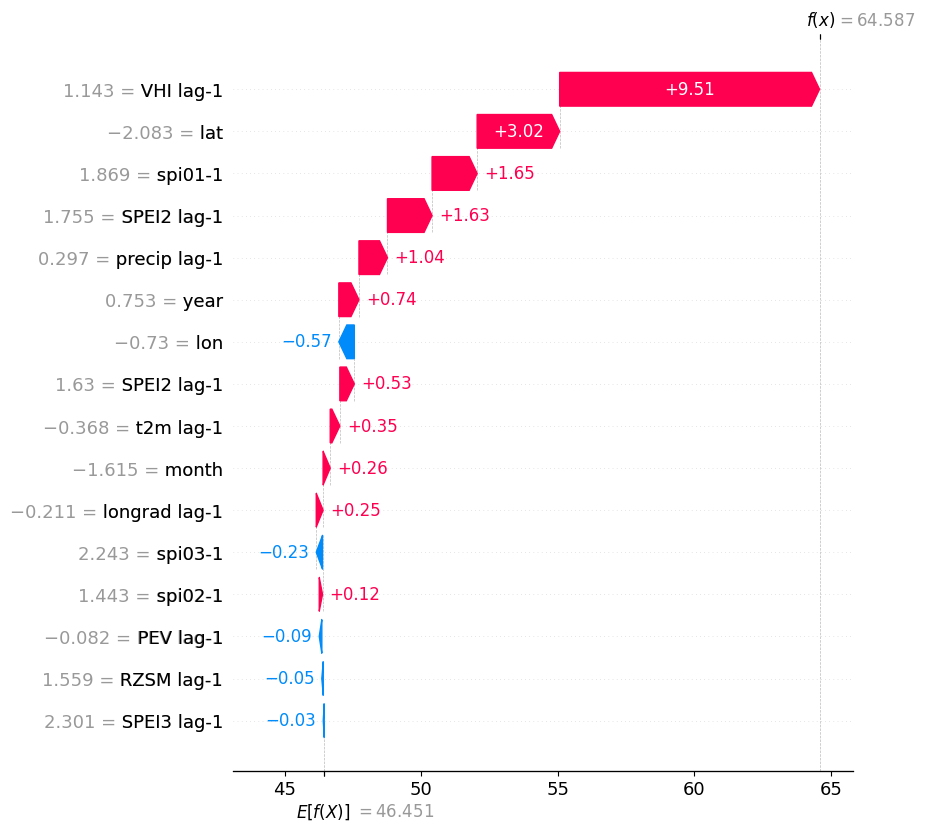

In [ ]:
shap.plots.waterfall(shap_values[0],max_display=16)

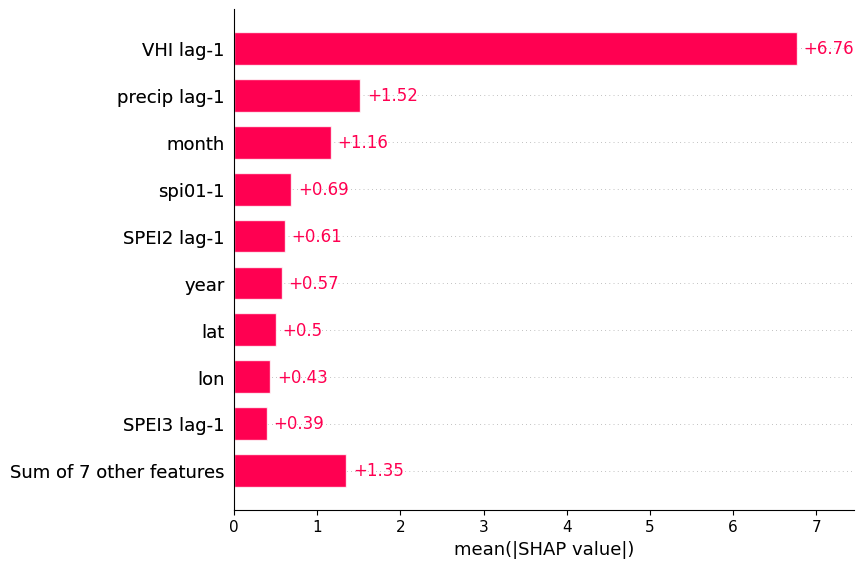

In [ ]:
shap.plots.bar(shap_values)

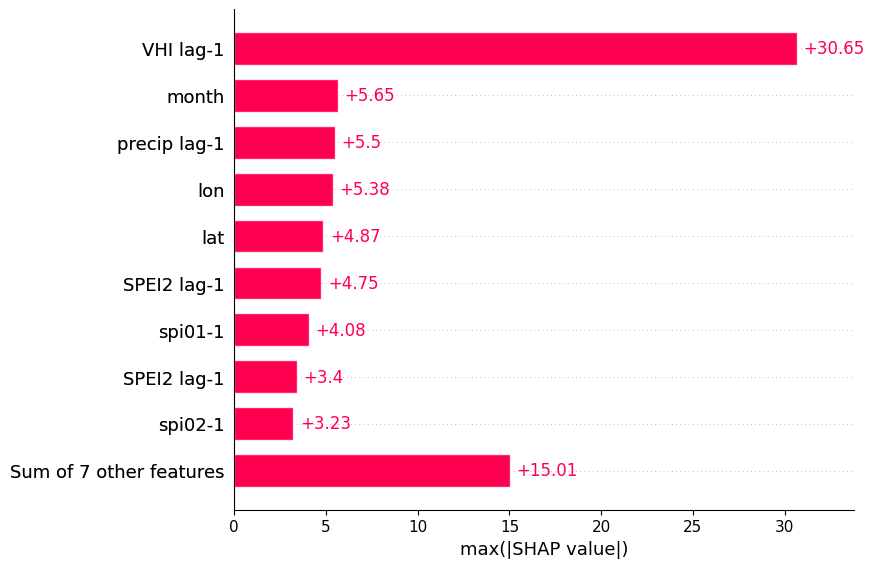

In [ ]:
shap.plots.bar(shap_values.abs.max(0))

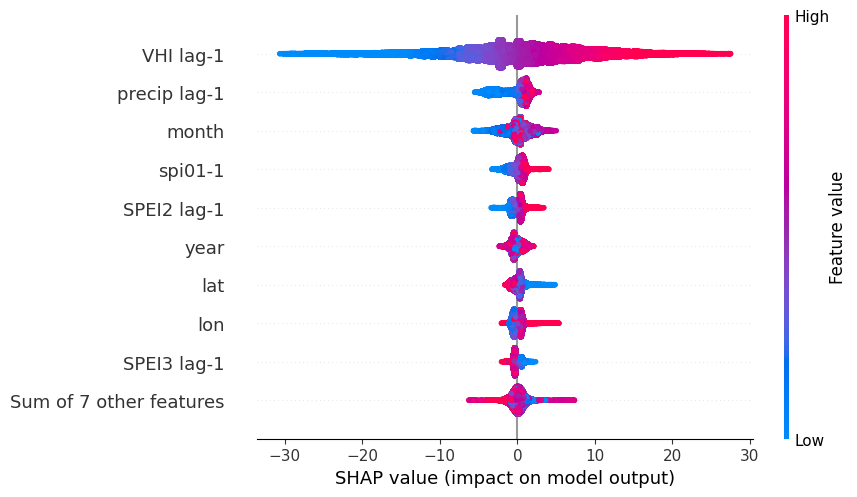

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
clustering = shap.utils.hclust(testx_df,GBM_out_df['testy'])

In [ ]:
shap.plots.bar(shap_values,clustering=clustering,max_display=16)